In [ ]:
# CODE:
# https://scikit-learn.org/stable/modules/grid_search.html#grid-search
# https://github.com/skorch-dev/skorch/issues/451
# https://tomaugspurger.github.io <- check
# https://ml.dask.org/hyper-parameter-search.html

In [1]:
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import LabelEncoder

In [7]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)

## Explore

In [3]:
with h5py.File('../data/usps.h5', 'r') as hf:
    train = hf.get('train')
    X_train = train.get('data')[:]
    y_train = train.get('target')[:]
    test = hf.get('test')
    X_test = test.get('data')[:]
    y_test = test.get('target')[:]
    
X_train.shape, y_train.shape

((7291, 256), (7291,))

In [4]:
np.c_[X_train, y_train].shape

(7291, 257)

In [5]:
label_df = pd.DataFrame(data=y_train)
print(label_df[0].value_counts())

0    1194
1    1005
2     731
6     664
3     658
4     652
7     645
9     644
5     556
8     542
Name: 0, dtype: int64


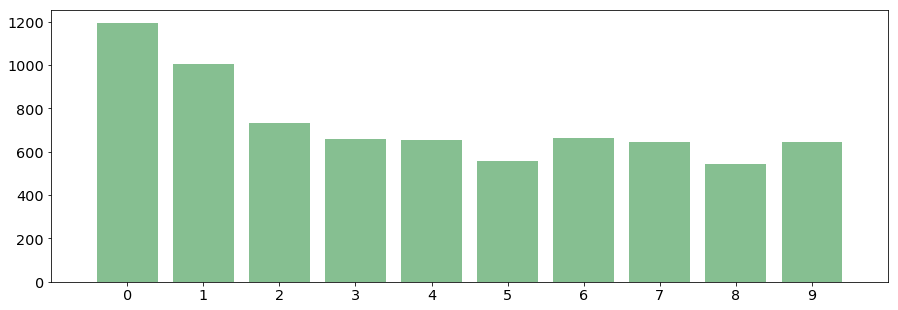

In [8]:
counts = np.bincount(y_train)
fig, ax = plt.subplots()
ax.bar(range(10), counts, width=0.8, align='center', color='#86bf91')
ax.set(xticks=range(10), xlim=[-1, 10])

plt.show()

In [10]:
train_df = pd.DataFrame(data=X_train)
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
count,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.00000,7291.000000,...,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000
mean,0.001791,0.009431,0.024424,0.056131,0.113266,0.194849,0.315504,0.477115,0.47368,0.357718,...,0.400727,0.569911,0.558219,0.342946,0.173145,0.081071,0.038903,0.021304,0.010355,0.002661
std,0.025856,0.075601,0.122132,0.180258,0.251330,0.314355,0.358016,0.384152,0.37649,0.373419,...,0.386447,0.376492,0.378668,0.362929,0.291277,0.207323,0.150415,0.114350,0.079499,0.033028
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000500,0.02500,0.000000,...,0.000000,0.169250,0.131000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140500,0.530500,0.50100,0.219500,...,0.323500,0.684000,0.668000,0.210500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.019000,0.304500,0.627250,0.848000,0.83725,0.719000,...,0.777000,0.917500,0.907500,0.673000,0.247750,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.819000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.796000


## Dataset

In [4]:
BATCH_SIZE = 128
INPUT_SIZE = 256
ENCODE_DIM = (64, 16)

FEAT_EPOCHS = 1000

device = torch.device("cpu")

In [ ]:
class USPSTrainDataset(Dataset):
    def __init__(self, filename):
        with h5py.File(filename, 'r') as hf:
            train = hf.get('train')
            self.X = train.get('data')[:]
            self.y = train.get('target')[:]
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        vector = self.X[index, :]
        label = self.y[index]
        
        return vector, label
            
class USPSTestDataset(Dataset):
    def __init__(self, filename):
        with h5py.File(filename, 'r') as hf:
            test = hf.get('test')
            self.X = test.get('data')[:]
            self.y = test.get('target')[:]
            
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        vector = self.X[index, :]
        label = self.y[index]
        
        return vector, label

## Feature Extraction - Vanilla Autoencoder

In [ ]:
train_dataset = USPSTrainDataset('../data/usps.h5')
test_dataset = USPSTestDataset('../data/usps.h5')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [1]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, encode_dim):
#         super(Autoencoder, self).__init__()
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, encode_dim[0]),
            nn.ReLU(True),
            nn.Linear(encode_dim[0], encode_dim[1]),
            nn.ReLU(True))

        self.decoder = nn.Sequential(             
            nn.Linear(encode_dim[1], encode_dim[0]),
            nn.ReLU(True),
            nn.Linear(encode_dim[0], input_size))

    def forward(self, x):
        x_enc = self.encoder(x)
        x_dec = self.decoder(x_enc)
        return x_dec, x_enc

In [ ]:
def train(epoch):
    for data in train_loader:
        vec, labels = data
        vec = Variable(vec, requires_grad=True).cpu()
        
        # ===================forward=====================
        dec, enc = model(vec)
        loss = distance(dec, vec)
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch + 1, FEAT_EPOCHS, loss.item()))
    return loss.item()

In [ ]:
writer = SummaryWriter()
model = Autoencoder().cpu()
distance = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1, momentum = 0.9)

for epoch in range(FEAT_EPOCHS):
    loss = train(epoch)
    writer.add_scalar('usps/mse', loss, epoch)
    
writer.close()

In [ ]:
writer.close()

In [ ]:
torch.save(model.state_dict(), './USPS_Feat_1000_lr_10')

## Model

In [ ]:
model = Autoencoder(INPUT_SIZE, ENCODE_DIM)
model.load_state_dict(torch.load('./USPS_Feat_1000_lr_01'))

In [ ]:
def to_latent(dataset_loader):
    model.eval()
    encs = torch.Tensor([])
    labels = []
    for data in dataset_loader:
        vec, label = data
        vec = Variable(vec, requires_grad=False).cpu()
        _, enc = model(vec)
        
        encs = torch.cat((encs, enc))
        labels.extend([l.tolist() for l in label])
        
    return encs.detach().numpy(), labels

In [ ]:
encs, labels = to_latent(train_loader)

In [ ]:
latent_df = pd.DataFrame(data=np.c_[encs, labels])

In [ ]:
latent_df.to_csv('../data/usps_latent.csv', sep='\t', encoding='utf-8')

In [ ]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [ ]:
clf = svm.SVC(gamma='auto')
latent_scores = cross_val_score(clf, encs, labels, cv=7)

In [ ]:
print(latent_scores.mean(), latent_scores.std())
latent_scores

In [ ]:
clf = svm.SVC(gamma='auto')
raw_scores = cross_val_score(clf, X_train, y_train, cv=7)

In [ ]:
print(raw_scores.mean(), raw_scores.std())
raw_scores

In [ ]:
test_encs, test_labels = to_latent(test_loader)

In [ ]:
clf = svm.SVC(gamma='auto')
clf.fit(encs, labels)

In [ ]:
clf.score(test_encs, test_labels)

In [ ]:
clf = svm.SVC(gamma='auto')
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

## Model selection

In [66]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from skorch import NeuralNet

In [67]:
clf = svm.SVC(gamma='auto')
param_grid = {
    'svm__C': [0.1, 1, 10, 100]
}
ppl = Pipeline([
    ('svm', clf)
])
search = GridSearchCV(ppl, 
                      param_grid, 
                      iid=False, 
                      cv=StratifiedKFold(n_splits=7),
                      return_train_score=False,
                      verbose=10)

In [ ]:
search.fit(X_train, y_train)

In [ ]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [ ]:
search.best_estimator_.score(X_test, y_test)

In [8]:
class AutoencoderPipeline(NeuralNet):
    def get_loss(self, y_pred, y_true, *args, **kwargs):
        decoded, _encoded = y_pred
        return super().get_loss(decoded, y_true, *args, **kwargs)
    
    def fit(self, X, y=None, **fit_params):
        if not self.warm_start or not self.initialized_:
            self.initialize()

        self.partial_fit(X, X, **fit_params)
        return self
    
    def transform(self, X):
        _decoded, encoded = super().forward(X)
        return encoded.numpy()

In [9]:
autoenc = AutoencoderPipeline(
    module__input_size=256,
    module__encode_dim=(64, 16),
    module=Autoencoder,
    max_epochs=100,
    criterion=nn.MSELoss,
    optimizer__momentum=0.9,
    optimizer__lr=1,
    optimizer=torch.optim.SGD,
    verbose=0
)

In [68]:
clf = svm.SVC(gamma='auto')
param_grid = {
#     'autofeat__optimizer__lr': [0.1, 1],
    'autofeat__module__encode_dim': [(128, 64), (128, 32), (96, 24), (64, 16), (64, 8)],
    'svm__C': [10, 100]
}

best_grid = {
    'autofeat__module__encode_dim': [(128, 64), (128, 32), (96, 24), (64, 16)],
    'svm__C': [10, 100]
}

ppl = Pipeline([
    ('autofeat', autoenc),
    ('svm', clf)
])

gs = GridSearchCV(ppl, 
                  best_grid, 
                  verbose=10,
                  cv=StratifiedKFold(n_splits=7),
                  n_jobs=-1)

In [63]:
gs.fit(X_train, y_train)

Fitting 7 folds for each of 8 candidates, totalling 56 fits
[CV] autofeat__module__encode_dim=(128, 64), svm__C=10 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  autofeat__module__encode_dim=(128, 64), svm__C=10, score=0.9732313575525813, total=  33.7s
[CV] autofeat__module__encode_dim=(128, 64), svm__C=10 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.7s remaining:    0.0s


[CV]  autofeat__module__encode_dim=(128, 64), svm__C=10, score=0.9760536398467433, total=  42.2s
[CV] autofeat__module__encode_dim=(128, 64), svm__C=10 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV]  autofeat__module__encode_dim=(128, 64), svm__C=10, score=0.9616858237547893, total=  40.0s
[CV] autofeat__module__encode_dim=(128, 64), svm__C=10 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s


[CV]  autofeat__module__encode_dim=(128, 64), svm__C=10, score=0.978866474543708, total=  40.1s
[CV] autofeat__module__encode_dim=(128, 64), svm__C=10 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.7min remaining:    0.0s


[CV]  autofeat__module__encode_dim=(128, 64), svm__C=10, score=0.9817131857555341, total=  42.9s
[CV] autofeat__module__encode_dim=(128, 64), svm__C=10 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min remaining:    0.0s


[CV]  autofeat__module__encode_dim=(128, 64), svm__C=10, score=0.971126082771896, total=  44.6s
[CV] autofeat__module__encode_dim=(128, 64), svm__C=10 ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.2min remaining:    0.0s


[CV]  autofeat__module__encode_dim=(128, 64), svm__C=10, score=0.9749518304431599, total=  46.5s
[CV] autofeat__module__encode_dim=(128, 64), svm__C=100 ..............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  4.9min remaining:    0.0s


[CV]  autofeat__module__encode_dim=(128, 64), svm__C=100, score=0.9770554493307839, total=  47.7s
[CV] autofeat__module__encode_dim=(128, 64), svm__C=100 ..............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  5.8min remaining:    0.0s


[CV]  autofeat__module__encode_dim=(128, 64), svm__C=100, score=0.9712643678160919, total=  45.5s
[CV] autofeat__module__encode_dim=(128, 64), svm__C=100 ..............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  6.5min remaining:    0.0s


[CV]  autofeat__module__encode_dim=(128, 64), svm__C=100, score=0.9693486590038314, total=  47.8s
[CV] autofeat__module__encode_dim=(128, 64), svm__C=100 ..............
[CV]  autofeat__module__encode_dim=(128, 64), svm__C=100, score=0.9750240153698367, total=  47.0s
[CV] autofeat__module__encode_dim=(128, 64), svm__C=100 ..............
[CV]  autofeat__module__encode_dim=(128, 64), svm__C=100, score=0.9797882579403272, total=  46.0s
[CV] autofeat__module__encode_dim=(128, 64), svm__C=100 ..............
[CV]  autofeat__module__encode_dim=(128, 64), svm__C=100, score=0.9701636188642926, total=  50.0s
[CV] autofeat__module__encode_dim=(128, 64), svm__C=100 ..............
[CV]  autofeat__module__encode_dim=(128, 64), svm__C=100, score=0.9739884393063584, total=  44.0s
[CV] autofeat__module__encode_dim=(128, 32), svm__C=10 ...............
[CV]  autofeat__module__encode_dim=(128, 32), svm__C=10, score=0.9741873804971319, total=  36.4s
[CV] autofeat__module__encode_dim=(128, 32), svm__C=10 ...

[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed: 46.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('autofeat', <class '__main__.AutoencoderPipeline'>[uninitialized](
  module=<class '__main__.Autoencoder'>,
  module__encode_dim=(64, 16),
  module__input_size=256,
)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'autofeat__module__encode_dim': [(128, 64), (128, 32), (96, 24), (64, 16)], 'svm__C': [10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [64]:
gs.best_score_

0.9754491839253875

In [ ]:
gs.best_estimator_.score()

In [21]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:42857 Dashboard: http://127.0.0.1:46427/status,Cluster Workers: 4 Cores: 8 Memory: 16.69 GB


In [22]:
from sklearn.externals import joblib

with joblib.parallel_backend('dask'):
    gs.fit(X_train, y_train)

Fitting 7 folds for each of 4 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
tornado.application - ERROR - Exception in callback <bound method Nanny.memory_monitor of <Nanny: tcp://127.0.0.1:32875, threads: 2>>
Traceback (most recent call last):
  File "/home/nemesszili/.conda/envs/gait_torch/lib/python3.6/site-packages/psutil/_common.py", line 341, in wrapper
    ret = self._cache[fun]
AttributeError: 'Process' object has no attribute '_cache'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/nemesszili/.conda/envs/gait_torch/lib/python3.6/site-packages/psutil/_pslinux.py", line 1514, in wrapper
    return fun(self, *args, **kwargs)
  File "/home/nemesszili/.conda/envs/gait_torch/lib/python3.6/site-packages/psutil/_pslinux.py", line 1746, in memory_info
    with open_binary("%s/%s/statm" % (self._procfs_path, self.pid)) as f:
  File "/home/nemesszili/.conda/envs/gait_torch/lib/python3.6/site-packages/psutil

KeyboardInterrupt: 

In [56]:
from dask_ml.model_selection import GridSearchCV as DaskGridSearchCV

dgs = DaskGridSearchCV(ppl, 
                       best_grid,
                       cv=StratifiedKFold(n_splits=7))

In [52]:
import dask.dataframe as dd
dd_X_train = dd.from_pandas(pd.DataFrame(data=X_train), npartitions=10)
dd_y_train = dd.from_pandas(pd.DataFrame(data=y_train), npartitions=10)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.1845,0.9310,0.4165,...,0.6520,0.9115,1.0000,0.7410,0.2630,0.0045,0.0000,0.0000,0.000,0.0
1,0.0,0.0,0.0,0.0935,0.1645,0.0955,0.0565,0.1645,0.0735,0.0000,...,0.1645,0.1645,0.4835,0.8805,0.8810,0.5630,0.4525,0.1645,0.086,0.0
2,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0020,...,0.0000,0.0000,0.0000,0.4455,1.0000,0.4105,0.0000,0.0000,0.000,0.0
3,0.0,0.0,0.0,0.0000,0.0000,0.3635,0.8420,0.9800,0.7250,0.4665,...,0.3410,1.0000,0.7680,0.0065,0.0000,0.0000,0.0000,0.0000,0.000,0.0
4,0.0,0.0,0.0,0.0000,0.0000,0.0360,0.3980,0.8755,0.7330,0.6170,...,0.7330,0.8195,1.0000,1.0000,0.8955,0.7195,0.4005,0.0585,0.000,0.0


In [57]:
%%time
dgs.fit(X_train, y_train)
print(dgs.cv_results_)

{'params': [{'autofeat__module__encode_dim': (128, 64), 'svm__C': 10}, {'autofeat__module__encode_dim': (128, 64), 'svm__C': 100}, {'autofeat__module__encode_dim': (128, 32), 'svm__C': 10}, {'autofeat__module__encode_dim': (128, 32), 'svm__C': 100}, {'autofeat__module__encode_dim': (96, 24), 'svm__C': 10}, {'autofeat__module__encode_dim': (96, 24), 'svm__C': 100}, {'autofeat__module__encode_dim': (64, 16), 'svm__C': 10}, {'autofeat__module__encode_dim': (64, 16), 'svm__C': 100}], 'mean_fit_time': array([580.35976265, 579.42765793, 598.21158357, 597.48921524,
       525.87829627, 526.53945013, 425.38152682, 425.53063703]), 'std_fit_time': array([17.77972932, 17.3473625 , 17.77235805, 18.1116907 , 26.53854533,
       26.93580177, 93.87323286, 94.19586357]), 'mean_score_time': array([3.71498969, 2.73893485, 2.25100453, 2.05092291, 1.89753407,
       1.86171152, 0.95281335, 0.80576249]), 'std_score_time': array([0.85422996, 0.51887139, 0.2857832 , 0.511198  , 0.34529336,
       0.40659089,

In [58]:
dgs.best_score_

0.9755863393224523

In [60]:
dgs.best_estimator_.score(X_test, y_test)

0.9436970602889886

In [61]:
dgs.best_params_

{'autofeat__module__encode_dim': (128, 64), 'svm__C': 100}